In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("car data.csv")

In [3]:
df.sample(5)

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
277,city,2015,9.70,13.600,21780,Petrol,Dealer,Manual,0
265,jazz,2017,6.50,8.700,21200,Petrol,Dealer,Manual,0
260,city,2016,9.15,13.600,29223,Petrol,Dealer,Manual,0
237,creta,2015,11.25,13.600,68000,Diesel,Dealer,Manual,0
146,Hero Extreme,2014,0.55,0.787,15000,Petrol,Individual,Manual,0


In [4]:
df.shape

(301, 9)

In [5]:
df.isna().values.any()

np.False_

In [6]:
print("Fuel Type: ", df.Fuel_Type.unique())
print("Seller Type: ", df.Seller_Type.unique())
print("Transmission: ", df.Transmission.unique())
print("Owner: ", df.Owner.unique())

Fuel Type:  ['Petrol' 'Diesel' 'CNG']
Seller Type:  ['Dealer' 'Individual']
Transmission:  ['Manual' 'Automatic']
Owner:  [0 1 3]


In [7]:
from datetime import datetime

df["Current_year"] = datetime.now().year

df["Year"] = df.Current_year - df.Year

In [8]:
df.drop(columns="Current_year", axis = 1, inplace = True)

In [9]:
dummy = pd.get_dummies(df[["Fuel_Type", "Seller_Type", "Transmission"]], drop_first = True)

df = pd.concat( [df, dummy], axis = 1)

df.drop(columns = ["Fuel_Type", "Seller_Type", "Transmission"], inplace = True)

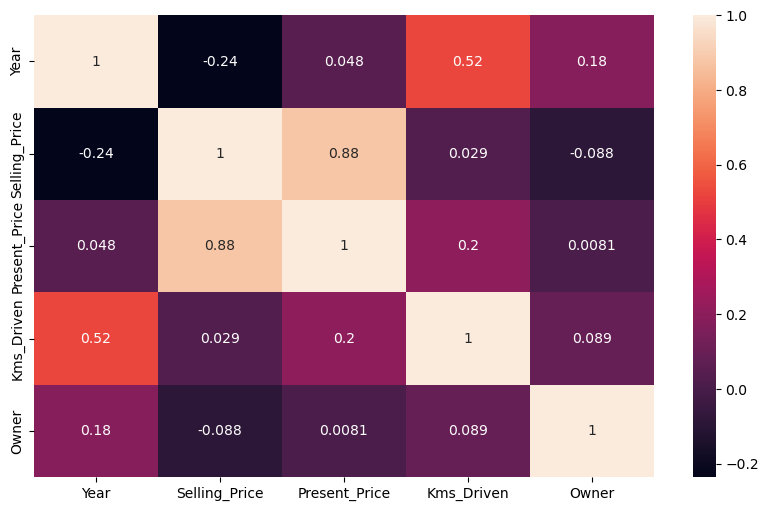

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize = (10, 6))
sns.heatmap(df.select_dtypes(include=['number']).corr(), annot=True)
plt.show()

In [11]:
df.Car_Name = df.Car_Name.str.lower()

dummy = pd.get_dummies(df.Car_Name, drop_first = True)
df = pd.concat([df, dummy], axis = 1)
df.drop("Car_Name", axis = 1, inplace = True)

In [12]:
X = df.drop(columns="Selling_Price")
y = df.Selling_Price

In [13]:
from sklearn.ensemble import ExtraTreesRegressor

etr = ExtraTreesRegressor()
etr.fit(X, y)
important_features = etr.feature_importances_

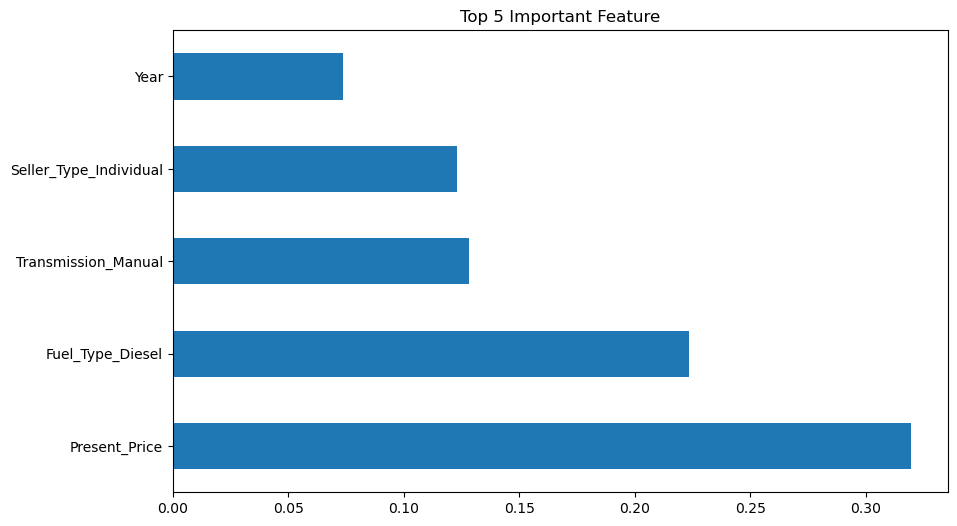

In [14]:
important_features = pd.Series(important_features, index = X.columns).sort_values(ascending = False)

plt.figure(figsize = (10, 6))
important_features[:5].plot(kind = "barh")
plt.title("Top 5 Important Feature")

plt.show()

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [17]:

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np

algos = {
    "Linear Regression": {
        "model": LinearRegression(),
        "param": {
            "fit_intercept": [True, False]
        }
    },
    "Decision Tree": {
        "model": DecisionTreeRegressor(),
        "param": {
            "criterion": ["squared_error", "friedman_mse"],  # 'mse' renamed to 'squared_error' in sklearn 1.0+
            "splitter": ["best", "random"]
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(),
        "param": {
            "n_estimators": [int(x) for x in np.linspace(100, 1200, 12)],
            "max_features": ["sqrt", "log2"],  # 'auto' removed in latest versions
            "max_depth": [int(x) for x in np.linspace(5, 30, 6)],
            "min_samples_split": [2, 5, 10, 15, 100],
            "min_samples_leaf": [1, 2, 5, 10]
        }
    }
}


In [18]:
from sklearn.model_selection import RandomizedSearchCV

best_models = {}
scores = []
for model_name, values in algos.items():
    model_tunning = RandomizedSearchCV(values["model"], values["param"], n_iter=10, cv = 5, n_jobs = -1)
    model_tunning.fit(X_train, y_train)
    
    best_models[model_name] = model_tunning
    scores.append({
        "Model": model_name,
        "Best Parameters": model_tunning.best_params_,
        "Best Score": model_tunning.best_score_
    })
    
pd.DataFrame(scores)

/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


,Model,Best Parameters,Best Score
0,Linear Regression,{'fit_intercept': True},0.245403
1,Decision Tree,"{'splitter': 'best', 'criterion': 'squared_err...",0.941264
2,Random Forest,"{'n_estimators': 1200, 'min_samples_split': 5,...",0.886302


In [19]:
for name, model in best_models.items():
    print(name, " : ", model.score(X_test, y_test))

Linear Regression  :  0.48489090629554177
Decision Tree  :  0.8466637492828489
Random Forest  :  0.6309466747436552


In [20]:
final_model = best_models["Random Forest"]

In [21]:
def predict_price(year, present_price, kms, owner, diesel, petrol, individual, manual, vehicle):
    vehicle_index = np.where(X.columns == vehicle.lower())[0][0]
    X_pred = np.zeros_like(X.columns)
    
    feature_list = [year, present_price, kms, owner, diesel, petrol, individual, manual]
    count = 0
    for f in feature_list:
        X_pred[count] = f
        count += 1
    
    if vehicle_index > 0:
        X_pred[vehicle_index] = 1
    
    result = final_model.predict([X_pred])
    
    return result

In [23]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

predict_price(7, 9.54, 43000, 0, 1, 0, 0, 1, "sx4")

array([7.48564168])

In [26]:
import pickle

with open("model.pkl", "wb") as f:
    pickle.dump(final_model, f)

In [27]:
import json

column_dict = {"data_columns": X.columns.to_list()}

with open("columns.json", "w") as f:
    json.dump(column_dict, f)